In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# ### Importing the Dataset
data = pd.read_csv("spam_ham_dataset.csv",encoding='latin1')
data.sample(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,label,text,label_num
5058,3023,ham,Subject: desk to desk ticket between nng and p...,0
2203,2252,ham,Subject: eastrans nomination effective january...,0
2215,567,ham,"Subject: wellhead\r\ndaren , here are some mon...",0
2385,1519,ham,Subject: new phone number & address\r\nthis is...,0
1508,5129,spam,Subject: re [ 8 ]\r\n,1
4178,3845,spam,"Subject: record sales , profits , earnings , s...",1
905,374,ham,Subject: 29 th changes\r\n- - - - - - - - - - ...,0
4933,4551,spam,Subject: fw : hot teen peeing\r\nwell well wel...,1
1437,2742,ham,"Subject: re : exxon company , usa global # 960...",0
4393,949,ham,Subject: el paso cuts to oasis\r\nfyi\r\n6 / 8...,0


In [2]:
data.shape
# remove redundant column
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)
data.drop(columns=['label_num'], inplace=True)
# rename to folow
data.rename(columns={'label': 'result', 'text': 'emails'}, inplace=True)
# remove newline,return, tab, white space
data['emails'] = data['emails'].str.replace(r'\r|\n|\t', ' ', regex=True)
data['emails'] = data['emails'].str.replace(r'\s+', ' ', regex=True).str.strip()
# check lack value nad remove overlap value
data.isnull().sum()
data.duplicated().sum()
data = data.drop_duplicates(keep='first')
data.shape
data.head(10)


,result,emails
0,ham,Subject: enron methanol ; meter # : 988291 thi...
1,ham,"Subject: hpl nom for january 9 , 2001 ( see at..."
2,ham,"Subject: neon retreat ho ho ho , we ' re aroun..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs this deal is to b...
5,ham,Subject: ehronline web address change this mes...
6,ham,Subject: spring savings certificate - take 30 ...
7,spam,Subject: looking for medication ? we ` re the ...
8,ham,Subject: noms / actual flow for 2 / 26 we agre...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000 ..."


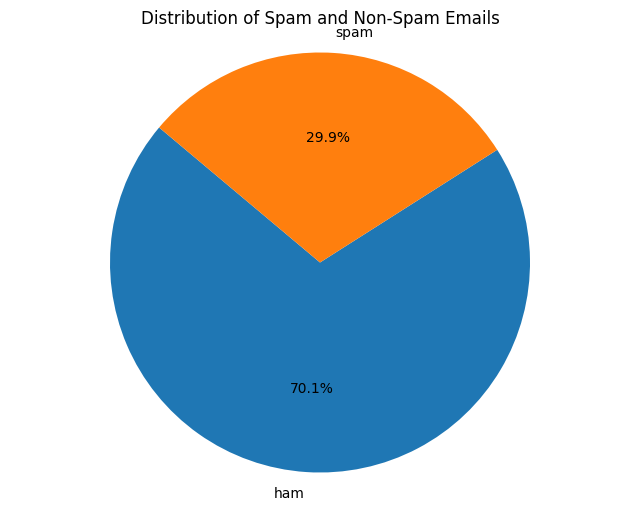

In [3]:
# count value in result column
data['result'].value_counts()
# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal') 
plt.show()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Average Length of Spam Emails: 1226.610123119015
Average Length of Ham Emails: 982.2919580419581


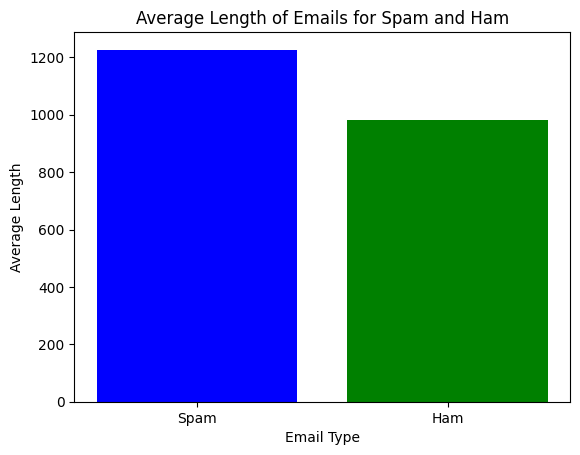

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Sentence of Spam Emails: 17.551983584131328
Average Sentence of Ham Emails: 11.720571095571096


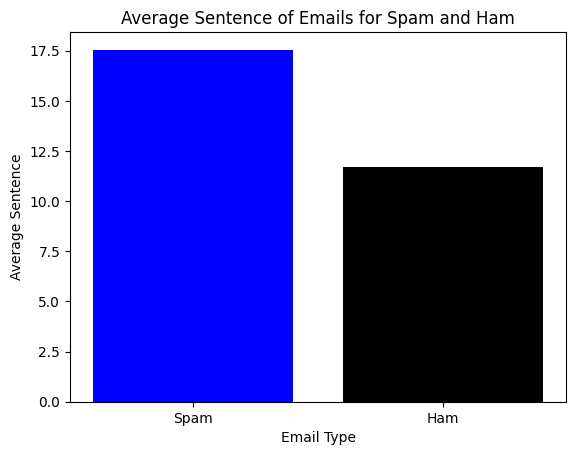

In [5]:
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)
# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

Correlation coefficient between email length and spam classification: 0.07281285976260278


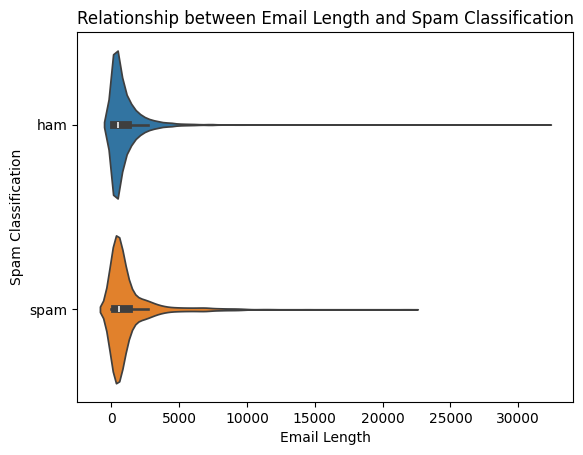

In [6]:
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()


The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.970736      0.533637
num_words     0.970736   1.000000      0.585506
num_sentence  0.533637   0.585506      1.000000


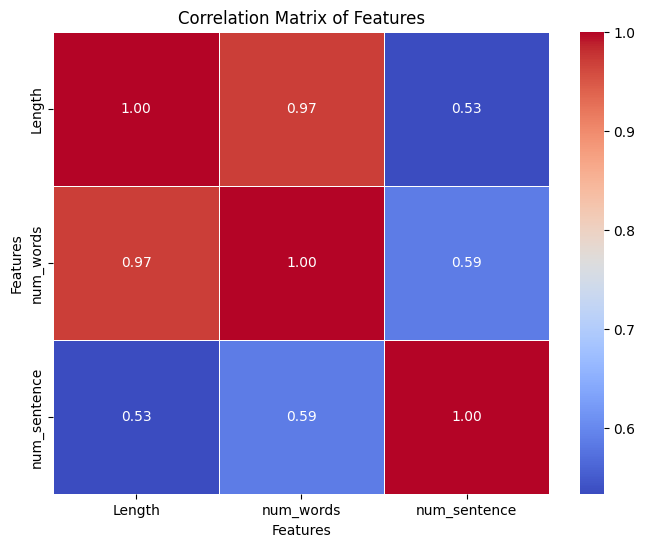

In [7]:
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(lambda x: len(x.split()))
data['num_sentence'] = data['emails'].apply(lambda x: x.count('.') + x.count('!') + x.count('?'))

correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [8]:
data['transform_text'] = data['emails'].str.lower()
# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)
# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])
# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])
# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])
# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))
# Display the preprocessed data
print(data[['emails', 'transform_text']].head())


                                              emails  \
0  Subject: enron methanol ; meter # : 988291 thi...   
1  Subject: hpl nom for january 9 , 2001 ( see at...   
2  Subject: neon retreat ho ho ho , we ' re aroun...   
3  Subject: photoshop , windows , office . cheap ...   
4  Subject: re : indian springs this deal is to b...   

                                      transform_text  
0  subject enron methanol meter 988291 follow not...  
1  subject hpl nom januari 9 2001 see attach file...  
2  subject neon retreat ho ho ho around wonder ti...  
3  subject photoshop window offic cheap main tren...  
4  subject indian spring deal book teco pvr reven...  


Top 10 Most Common Words in Spam Emails:
subject: 1622 occurrences
3: 1229 occurrences
com: 989 occurrences
http: 981 occurrences
compani: 918 occurrences
2: 853 occurrences
price: 731 occurrences
1: 710 occurrences
0: 688 occurrences
e: 632 occurrences


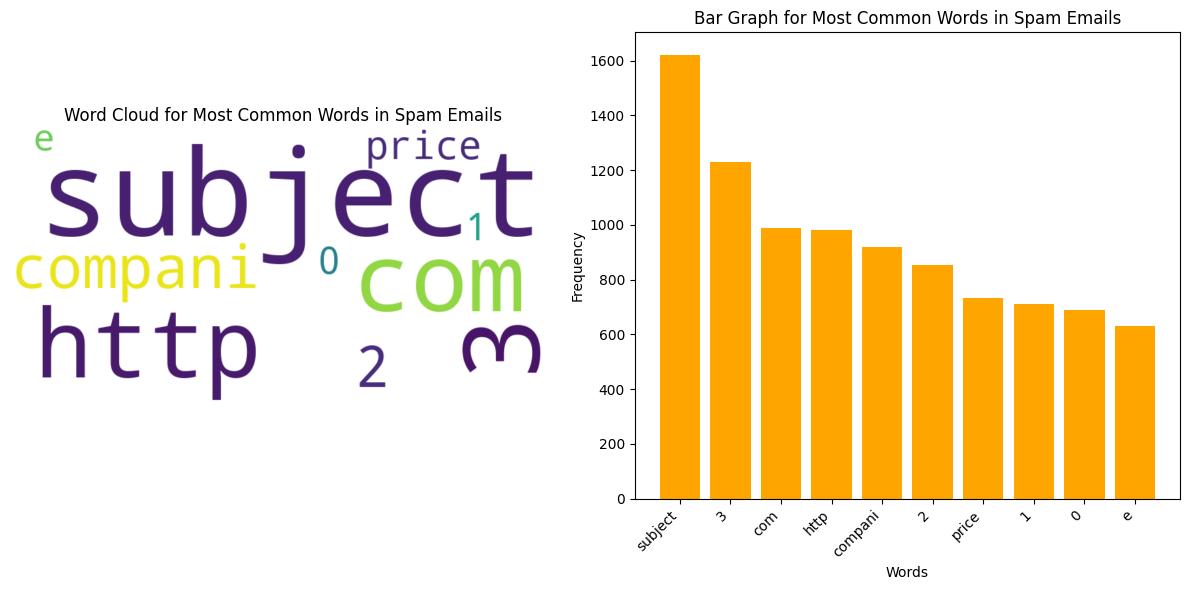

In [9]:
spam_emails = data[data['result'] == 'spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()
# Count occurrences of each word
word_counts = Counter(spam_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top 10 Most Common Words in ham Emails:
ect: 13457 occurrences
hou: 7044 occurrences
enron: 6289 occurrences
subject: 6024 occurrences
2000: 4201 occurrences
deal: 3338 occurrences
ga: 2714 occurrences
com: 2662 occurrences
meter: 2653 occurrences
pleas: 2607 occurrences


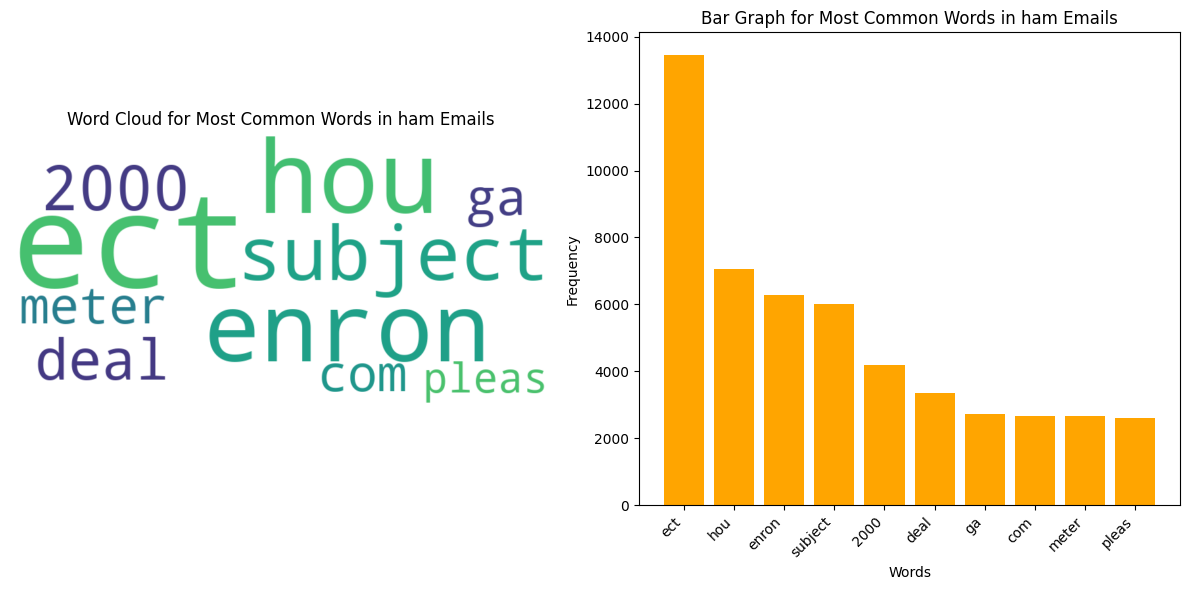

In [10]:
ham_emails = data[data['result'] == 'ham']['transform_text']
# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()
# Count occurrences of each word
word_counts = Counter(ham_words)
# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
# pre processing for modeling
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'] )
data.sample(2)

#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['emails']).toarray()
y = data['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

=== Support Vector Machine ===
Accuracy:        0.98
Precision Score: 0.97
Recall Score:    0.98
F1 Score:        0.97
ROC-AUC Score:   1.00
F1 Score (CV):   0.97
Confusion Matrix:
 [[677   8]
 [  7 287]]



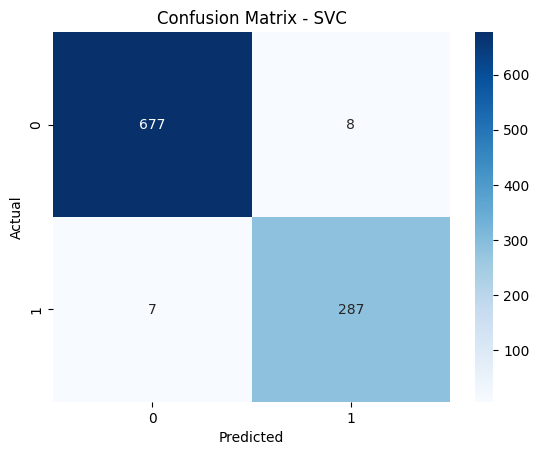

=== Naive Bayes ===
Accuracy:        0.96
Precision Score: 0.89
Recall Score:    0.98
F1 Score:        0.93
ROC-AUC Score:   0.99
F1 Score (CV):   0.92
Confusion Matrix:
 [[651  34]
 [  7 287]]



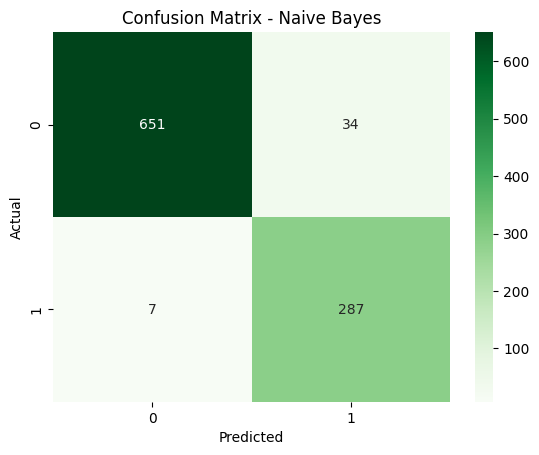

=== Random Forest ===
Accuracy:        0.97
Precision Score: 0.93
Recall Score:    0.96
F1 Score:        0.94
ROC-AUC Score:   1.00
F1 Score (CV):   0.95
Confusion Matrix:
 [[665  20]
 [ 13 281]]



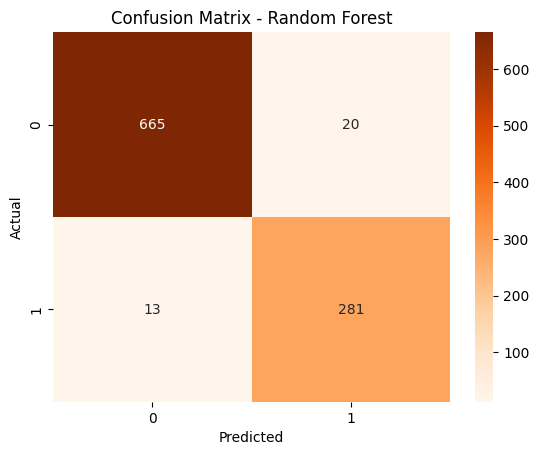

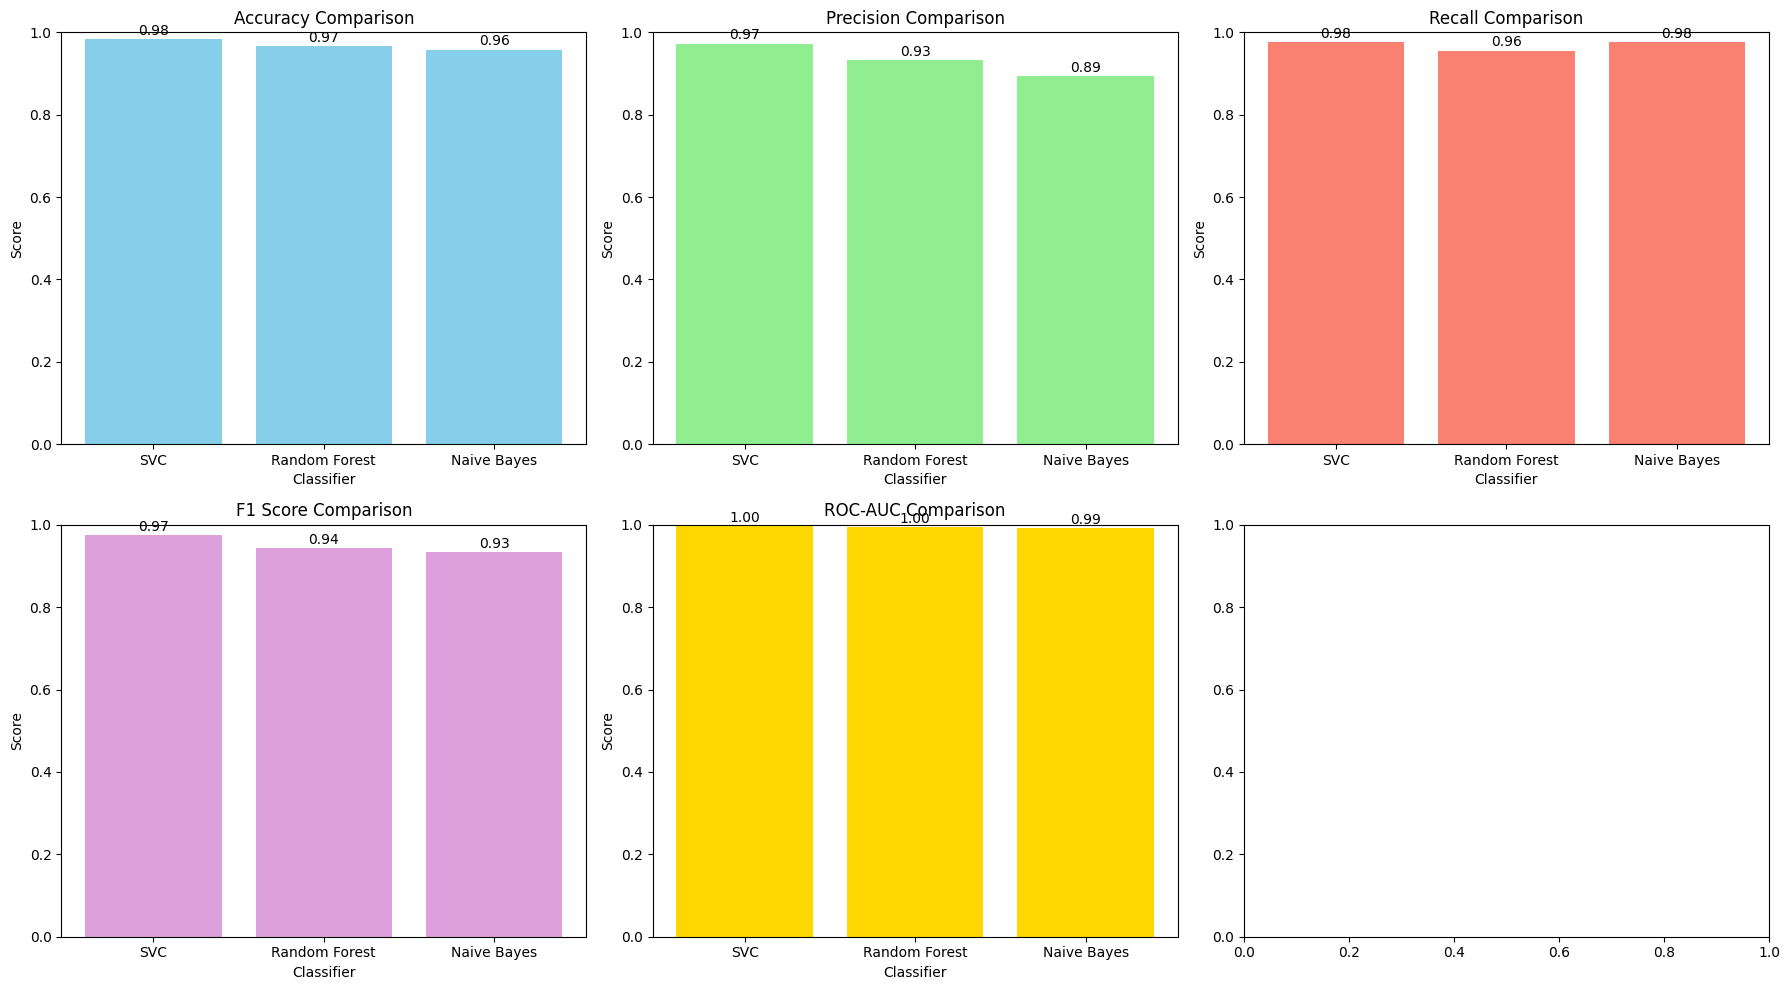

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score # IMPROVED ROC-AUC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score # IMPROVED cross_validation 
import matplotlib.pyplot as plt
import seaborn as sns 

# ------- SVC -------
svc_classifier = SVC(probability=True)  # apply probability to use roc_auc_score
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)

accuracy_svc  = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc    = recall_score(y_test, y_pred_svc)
f1_svc        = f1_score(y_test, y_pred_svc)
roc_auc_svc   = roc_auc_score(y_test, svc_classifier.predict_proba(X_test)[:, 1])  # IMPROVED ROC-AUC
cv_f1_svc = cross_val_score(svc_classifier, X_train, y_train, cv=5, scoring='f1')  # IMPROVED cross-validation 

print("=== Support Vector Machine ===")
print(f"Accuracy:        {accuracy_svc:.2f}")
print(f"Precision Score: {precision_svc:.2f}")
print(f"Recall Score:    {recall_svc:.2f}")
print(f"F1 Score:        {f1_svc:.2f}")
print(f"ROC-AUC Score:   {roc_auc_svc:.2f}")             # IMPROVED ROC-AUC
print(f"F1 Score (CV):   {cv_f1_svc.mean():.2f}")        # IMPROVED cross-validation 
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print()

#  NEW: Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------- Naive Bayes -------
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

accuracy_nb  = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb    = recall_score(y_test, y_pred_nb)
f1_nb        = f1_score(y_test, y_pred_nb)
roc_auc_nb   = roc_auc_score(y_test, nb_classifier.predict_proba(X_test)[:, 1])  # IMPROVED ROC-AUC
cv_f1_nb = cross_val_score(nb_classifier, X_train, y_train, cv=5, scoring='f1')  # IMPROVED cross-validation

print("=== Naive Bayes ===")
print(f"Accuracy:        {accuracy_nb:.2f}")
print(f"Precision Score: {precision_nb:.2f}")
print(f"Recall Score:    {recall_nb:.2f}")
print(f"F1 Score:        {f1_nb:.2f}")
print(f"ROC-AUC Score:   {roc_auc_nb:.2f}")              # IMPROVED ROC-AUC
print(f"F1 Score (CV):   {cv_f1_nb.mean():.2f}")         # IMPROVED cross-validation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print()

# Impro Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------- Random Forest -------
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf  = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf    = recall_score(y_test, y_pred_rf)
f1_rf        = f1_score(y_test, y_pred_rf)
roc_auc_rf   = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])  # IMPROVED ROC-AUC
cv_f1_rf = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='f1')  # IMPROVED cross-validation

print("=== Random Forest ===")
print(f"Accuracy:        {accuracy_rf:.2f}")
print(f"Precision Score: {precision_rf:.2f}")
print(f"Recall Score:    {recall_rf:.2f}")
print(f"F1 Score:        {f1_rf:.2f}")
print(f"ROC-AUC Score:   {roc_auc_rf:.2f}")              # IMPROVED ROC-AUC
print(f"F1 Score (CV):   {cv_f1_rf.mean():.2f}")         # IMPROVED cross-validation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print()

# Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ------- Bar Chart -------
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies  = [accuracy_svc, accuracy_rf, accuracy_nb]
precisions  = [precision_svc, precision_rf, precision_nb]
recalls     = [recall_svc, recall_rf, recall_nb]
f1_scores   = [f1_svc, f1_rf, f1_nb]                  
roc_aucs    = [roc_auc_svc, roc_auc_rf, roc_auc_nb]   # IMPROVED ROC-AUC

fig, axes = plt.subplots(2, 3, figsize=(18, 10))       

metrics = [('Accuracy', accuracies, axes[0,0], 'skyblue'),
           ('Precision', precisions, axes[0,1], 'lightgreen'),
           ('Recall', recalls, axes[0,2], 'salmon'),
           ('F1 Score', f1_scores, axes[1,0], 'plum'),
           ('ROC-AUC', roc_aucs, axes[1,1], 'gold')]   # IMPROVED ROC-AUC

for title, scores, ax, color in metrics:
    ax.bar(classifiers, scores, color=color)
    ax.set_title(f'{title} Comparison')
    ax.set_ylim(0, 1)
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, f'{v:.2f}', ha='center')
    ax.set_ylabel('Score')
    ax.set_xlabel('Classifier')

plt.tight_layout()
plt.show()


In [13]:
new_emails = [
    #"Get a free iPhone now!",
    "Good moring" ,
    "Congratulations! We won",
    "Reminder: Meeting at 7 AM tomorrow.",
    "We will met at the library tomorrow",
    "See you later." 
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Good moring' is predicted as spam.
'Congratulations! We won' is predicted as spam.
'Reminder: Meeting at 7 AM tomorrow.' is predicted as ham.
'We will met at the library tomorrow' is predicted as ham.
'See you later.' is predicted as spam.


In [14]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])
    
    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()
    
    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)
    
    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
# Predict whether the input email is spam or ham
user_email1 = input("Enter the email text 1: ")
predict_email(user_email1)
user_email2 = input("Enter the email text 2: ")
predict_email(user_email2)

Enter the email text 1:  nice to see you


The email is predicted as spam.


Enter the email text 2:  we will meet at the restaurant


The email is predicted as ham.
